<a href="https://colab.research.google.com/github/JSchoonmaker/blockchain_projects/blob/main/CryptoPunks_EDA_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CryptoPunks EDA

by Jeanna Schoonmaker
Oct 2021

### Installing and importing necessary libraries

In [20]:
# installing this pkg helps with unnesting some of the json returned from Flipside
!pip install flat-table

In [21]:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import requests
import flat_table
import json
import os
import numpy as np
import pickle
from datetime import datetime

### Next, let's bring in the data. We'll be working from a couple of data sources - a csv of historical punks transactions through 12/30/2020, and then data compiled from an API download from Flipside Crypto for transactions occurring in 2021. 

### First, the easy part - loading the csv

In [23]:
punks_url = 'https://raw.githubusercontent.com/Omni-Analytics-Group/eth-data-science-course/master/courses/Module%201/punks.csv'

In [24]:
df = pd.read_csv(punks_url, encoding='unicode_escape')

In [25]:
df.head()

,Transaction,From,To,Crypto,USD,Txn,ID,Sex,Type,Skin,Slots,Rank
0,Sold,0xf5099e,14715954,25.00,2822.0,2018-11-30,0,Girl,Female,Mid,3,3682560000%
1,Sold,0x00d7c9,10528156,1.60,386.0,2017-07-07,0,Girl,Female,Mid,3,3682560000%
2,Sold,0xc352b5,55241,0.98,320.0,2017-06-23,0,Girl,Female,Mid,3,3682560000%
3,Claimed,NaN,12800693,NaN,NaN,2017-06-23,0,Girl,Female,Mid,3,3682560000%
4,Sold,EliteCat,0xcf6165,60.00,36305.0,2020-11-30,1,Guy,Male,Dark,2,2050240500%


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17554 entries, 0 to 17553
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Transaction  17554 non-null  object 
 1   From         7554 non-null   object 
 2   To           17554 non-null  object 
 3   Crypto       7554 non-null   float64
 4   USD          7554 non-null   float64
 5   Txn          17554 non-null  object 
 6   ID           17554 non-null  int64  
 7   Sex          17554 non-null  object 
 8   Type         17554 non-null  object 
 9   Skin         17554 non-null  object 
 10  Slots        17554 non-null  int64  
 11  Rank         17554 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 1.6+ MB


### It looks like the "Txn" field has our date info, but is in string format. Let's change it to datetime format and then take a look at the max and min dates in this dataset.

In [27]:
df['Txn']= pd.to_datetime(df['Txn'])

print('The earliest transaction date in the dataset is: ')
print(df.Txn.min())

print('\n\nThe latest transaction date in the dataset is: ')
print(df.Txn.max())

The earliest transaction date in the dataset is: 
2017-06-23 00:00:00


The latest transaction date in the dataset is: 
2020-12-30 00:00:00


### Let's run df.info again to ensure changing Txn to datetime worked.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17554 entries, 0 to 17553
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Transaction  17554 non-null  object        
 1   From         7554 non-null   object        
 2   To           17554 non-null  object        
 3   Crypto       7554 non-null   float64       
 4   USD          7554 non-null   float64       
 5   Txn          17554 non-null  datetime64[ns]
 6   ID           17554 non-null  int64         
 7   Sex          17554 non-null  object        
 8   Type         17554 non-null  object        
 9   Skin         17554 non-null  object        
 10  Slots        17554 non-null  int64         
 11  Rank         17554 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 1.6+ MB


### Looks good! Let's dig into the data more.

In [29]:
df.describe(include='all', datetime_is_numeric=True) # including "all" as a parameter in df.describe gives us info on non numeric fields as well 

,Transaction,From,To,Crypto,USD,Txn,ID,Sex,Type,Skin,Slots,Rank
count,17554,7554,17554,7554.000000,7554.000000,17554,17554.000000,17554,17554,17554,17554.000000,17554
unique,2,682,1524,NaN,NaN,NaN,NaN,2,5,7,NaN,4007
top,Claimed,Hemba,12800693,NaN,NaN,NaN,NaN,Guy,Male,Mid,NaN,2213293500%
freq,10000,1058,990,NaN,NaN,NaN,NaN,11379,11152,5307,NaN,45
mean,NaN,NaN,NaN,2.389854,867.305033,2018-06-05 21:18:33.592233216,5193.788481,NaN,NaN,NaN,2.778227,NaN
min,NaN,NaN,NaN,0.010000,0.010000,2017-06-23 00:00:00,0.000000,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,0.300000,72.000000,2017-06-23 00:00:00,2906.000000,NaN,NaN,NaN,2.000000,NaN
50%,NaN,NaN,NaN,1.000000,232.500000,2017-06-23 00:00:00,5189.000000,NaN,NaN,NaN,3.000000,NaN
75%,NaN,NaN,NaN,2.900000,1003.250000,2019-12-09 00:00:00,7557.000000,NaN,NaN,NaN,3.000000,NaN
max,NaN,NaN,NaN,189.990000,137522.000000,2020-12-30 00:00:00,9999.000000,NaN,NaN,NaN,7.000000,NaN


### Initial thoughts after first pass at this data:
1. There are 17554 transactions in this dataset, and 10019 of them occurred on Jun 23, 2017 when the punks were first made available. The top transaction type is "Claimed." **More than half of our transactions in this dataset are from the initial 'claims' of the punks.**

2. The "From" and "To" fields indicate the number of unique users who transacted in this dataset. **Interesting that with 10,000 punks, there are only 682 unique users on the selling side of the transaction, with 1524 users on the buying/claiming side of the transaction.**

3. The "Sex," "Type," and "Skin" columns refer to descriptive Punks attributes. The ID is the Punk identifier. "Slots" and "Rank" offer additional data about the sales of the Punks.

4. Ethereum addresses are 40 character hexadecimal strings. However, in this dataset, the "From" and "To" columns, which show the Eth addresses of the users buying and selling the Punks, have been shortened to 8 characters. Some addresses also use a name instead of the shortened hex string.

5. The column titled "Crypto" is referring to the cryptocurrency Ether. **With a mean of 2.39 Eth/857.31 USD and a standard deviation of 6.12 Eth/2833.27 USD, we have a lot of variation in our data.** Let's take a look at it in a scatterplot.

[Text(0.5, 1.0, '2017 - 2020 Punks Purchases')]

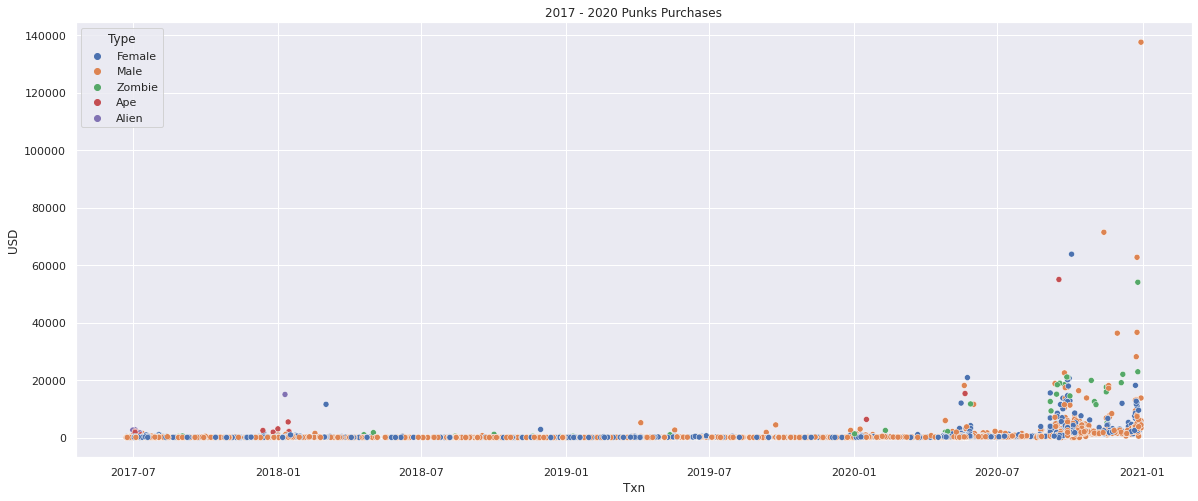

In [30]:
plt.figure(figsize=(20, 8))
sns.set(style="darkgrid")
sns.scatterplot(x=df.Txn, y=df.USD, hue = df.Type).set(title='2017 - 2020 Punks Purchases')

### There was very little CryptoPunks sales activity until 2020, but summer through fall of 2020 became much more active. There also appears to be a few outliers in our data.

### One more quick analysis of this data - with only 682 users selling and 1524 users responsible for 17554 sales transactions, let's see which users are responsible for the most buying and selling transactions in this dataset.

In [70]:
n = 20
print('The users with the most selling transactions are:')
df['From'].value_counts()[:n]

The users with the most selling transactions are:


Hemba        1058
Pranksy       496
0x00d7c9      481
55241         170
Carlini8      142
Cyborg        113
jmg            96
0x8234be       83
0x1a96af       83
GoWest23       81
Dude_Nak
      78
CPyrc          70
0xe45df5       69
ross_VRO
      69
Michel_M
      67
0xc24f57       66
0x58164b       64
NeonNFT        61
juggerna
      59
Pixls          58
Name: From, dtype: int64

In [71]:
print('The users with the most buying transactions are:')
df['To'].value_counts()[:n]

The users with the most buying transactions are:


12800693    990
Hemba       930
0x00d7c9    886
13358210    723
48543       473
Pranksy     464
7293485     320
6689278     304
13401139    193
sov         169
GoWest23    162
4774681     160
0xe45df5    157
Carlini8    146
55241       142
2553668     141
12221644    129
0xe4d36b    121
0x13816f    120
Cyborg      116
Name: To, dtype: int64

### These are results we will look into further in Part 3.

### It is great to be looking at understandable blockchain data, but what if you need to access raw blockchain data and clean it yourself? 

### Now let's bring in 2021's data from Flipside Crypto using the process I introduced in Part 1.

In [12]:
url = ('https://api.flipsidecrypto.com/api/v2/queries/99990404-5727-40cb-989a-f9d66738bdca/data/latest')

response = requests.get(url)  

print(f"Request returned {response.status_code} : '{response.reason}'")

payload = response.json()

# uncomment the following lines if you'd like to see the first row of data being returned from the API
# import pprint
# pp = pprint.PrettyPrinter(indent=1)
# pp.pprint(payload[0])

Request returned 200 : 'OK'


### Using json.normalize helps to unpack the json response

In [13]:
df_flip = pd.json_normalize(payload)

In [14]:
df_flip.head()

,BLOCK_ID,BLOCK_TIMESTAMP,CONTRACT_ADDRESS,CONTRACT_NAME,EVENT_INDEX,EVENT_INPUTS,EVENT_NAME,EVENT_REMOVED,TX_FROM_ADDRESS,TX_FROM_ADDRESS_NAME,TX_FROM_LABEL,TX_FROM_LABEL_SUBTYPE,TX_FROM_LABEL_TYPE,TX_ID,TX_SUCCEEDED,TX_TO_ADDRESS,TX_TO_ADDRESS_NAME,TX_TO_LABEL,TX_TO_LABEL_SUBTYPE,TX_TO_LABEL_TYPE
0,11937865,2021-02-27T06:56:17Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,198,"{\n ""fromAddress"": ""0xb4bb4156e5e6ca5d81041f6...",PunkBought,False,0x701f373df763308d96d8537822e8f9b2bae4e847,None,None,None,None,0xbeb2c0c8fa4c16d2c9f1c41b07893afd4412c509d5a7...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft
1,11930860,2021-02-26T05:15:57Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,76,"{\n ""fromAddress"": ""0x47d4f20ae83bcd350105f19...",PunkBought,False,0xff0bd4aa3496739d5667adc10e2b843dfab5712b,None,None,None,None,0x639928180df58e9aa25887e737708a0fe62180e76eff...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft
2,11931210,2021-02-26T06:28:37Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,220,"{\n ""fromAddress"": ""0x6f4a2d3a4f47f9c647d86c9...",PunkBought,False,0x92041c816fa960e2352f49ac118771307c416a17,None,None,None,None,0x7b78a09686c4b6b5b5d7b460f5432f02b7f7956c907c...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft
3,11931249,2021-02-26T06:38:57Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,144,"{\n ""fromAddress"": ""0x86af6e8b92221c37c2da388...",PunkBought,False,0xb53349160e38739b37e4bbfcf950ed26e26fcb41,None,None,None,None,0x667fa37e8b64e102c08e32fbd67ddc45b5fb4213fadf...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft
4,11931329,2021-02-26T06:57:23Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,47,"{\n ""fromAddress"": ""0x5f5df42ddb92d621176a59c...",PunkBought,False,0x696ed7b26f4b019ceec78dc8b9140ad64a6f354b,None,None,None,None,0xba98bee1739754e49e9676b1693c7e6a9bf4cb65d7ab...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft


### Looks pretty good, but we still have a nested json result in our EVENT_INPUTS column. We'll use flat-table to unpack that

In [15]:
df_flip['EVENT_INPUTS'] = df_flip['EVENT_INPUTS'].apply(lambda x:json.loads(x))
df_flip = flat_table.normalize(df_flip)

In [16]:
df_flip.head()

,index,BLOCK_ID,BLOCK_TIMESTAMP,CONTRACT_ADDRESS,CONTRACT_NAME,EVENT_INDEX,EVENT_NAME,EVENT_REMOVED,TX_FROM_ADDRESS,TX_FROM_ADDRESS_NAME,TX_FROM_LABEL,TX_FROM_LABEL_SUBTYPE,TX_FROM_LABEL_TYPE,TX_ID,TX_SUCCEEDED,TX_TO_ADDRESS,TX_TO_ADDRESS_NAME,TX_TO_LABEL,TX_TO_LABEL_SUBTYPE,TX_TO_LABEL_TYPE,EVENT_INPUTS.value,EVENT_INPUTS.toAddress,EVENT_INPUTS.punkIndex,EVENT_INPUTS.fromAddress
0,0,11937865,2021-02-27T06:56:17Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,198,PunkBought,False,0x701f373df763308d96d8537822e8f9b2bae4e847,None,None,None,None,0xbeb2c0c8fa4c16d2c9f1c41b07893afd4412c509d5a7...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft,7756279631452241920,0x701f373df763308d96d8537822e8f9b2bae4e847,920,0xb4bb4156e5e6ca5d81041f616c27dffb253b7845
1,1,11930860,2021-02-26T05:15:57Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,76,PunkBought,False,0xff0bd4aa3496739d5667adc10e2b843dfab5712b,None,None,None,None,0x639928180df58e9aa25887e737708a0fe62180e76eff...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft,-5540232221128654848,0xff0bd4aa3496739d5667adc10e2b843dfab5712b,5569,0x47d4f20ae83bcd350105f199f900e6e6104dab6a
2,2,11931210,2021-02-26T06:28:37Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,220,PunkBought,False,0x92041c816fa960e2352f49ac118771307c416a17,None,None,None,None,0x7b78a09686c4b6b5b5d7b460f5432f02b7f7956c907c...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft,6553255926290448384,0x92041c816fa960e2352f49ac118771307c416a17,4460,0x6f4a2d3a4f47f9c647d86c929755593911ee91ec
3,3,11931249,2021-02-26T06:38:57Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,144,PunkBought,False,0xb53349160e38739b37e4bbfcf950ed26e26fcb41,None,None,None,None,0x667fa37e8b64e102c08e32fbd67ddc45b5fb4213fadf...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft,4243255926290448384,0xb53349160e38739b37e4bbfcf950ed26e26fcb41,4689,0x86af6e8b92221c37c2da388df1f175d94047bdb3
4,4,11931329,2021-02-26T06:57:23Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,47,PunkBought,False,0x696ed7b26f4b019ceec78dc8b9140ad64a6f354b,None,None,None,None,0xba98bee1739754e49e9676b1693c7e6a9bf4cb65d7ab...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft,-7903488147419103232,0x696ed7b26f4b019ceec78dc8b9140ad64a6f354b,6431,0x5f5df42ddb92d621176a59c437f54fcf1bb4be23


In [17]:
print('The earliest transaction date in the dataset is: ')
print(df_flip.BLOCK_TIMESTAMP.min())

print('\n\nThe latest transaction date in the dataset is: ')
print(df_flip.BLOCK_TIMESTAMP.max())

The earliest transaction date in the dataset is: 
2020-01-12T18:17:36Z


The latest transaction date in the dataset is: 
2021-11-01T23:40:04Z


In [18]:
df_flip.describe(include='all')

,index,BLOCK_ID,BLOCK_TIMESTAMP,CONTRACT_ADDRESS,CONTRACT_NAME,EVENT_INDEX,EVENT_NAME,EVENT_REMOVED,TX_FROM_ADDRESS,TX_FROM_ADDRESS_NAME,TX_FROM_LABEL,TX_FROM_LABEL_SUBTYPE,TX_FROM_LABEL_TYPE,TX_ID,TX_SUCCEEDED,TX_TO_ADDRESS,TX_TO_ADDRESS_NAME,TX_TO_LABEL,TX_TO_LABEL_SUBTYPE,TX_TO_LABEL_TYPE,EVENT_INPUTS.value,EVENT_INPUTS.toAddress,EVENT_INPUTS.punkIndex,EVENT_INPUTS.fromAddress
count,14068.000000,1.406800e+04,14068,14068,14068,14068.000000,14068,14068,14068,7,24,24,21,14068,14068,14068,13722,13722,13722,13722,14068.0,14068,14068.0,14068
unique,NaN,NaN,13102,1,1,NaN,1,1,4012,5,7,2,2,13911,1,26,1,1,1,1,2351.0,3846,5235.0,2807
top,NaN,NaN,2021-07-30T23:16:40Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,NaN,PunkBought,False,0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459,suma,idex,general_contract,dapp,0xbdbe5f20bd1dcd5c7ab0c5d5c445aefc8fda504e44e7...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft,0.0,0x0000000000000000000000000000000000000000,5575.0,0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647
freq,NaN,NaN,86,14068,14068,NaN,14068,14068,278,3,8,14,11,45,14068,13722,13722,13722,13722,13722,2135.0,1872,14.0,347
mean,7033.500000,1.214579e+07,NaN,NaN,NaN,131.261800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4061.226128,9.190436e+05,NaN,NaN,NaN,99.101146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,9.267683e+06,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3516.750000,1.185077e+07,NaN,NaN,NaN,52.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,7033.500000,1.220676e+07,NaN,NaN,NaN,110.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,10550.250000,1.293695e+07,NaN,NaN,NaN,193.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df_flip.columns

Index(['index', 'BLOCK_ID', 'BLOCK_TIMESTAMP', 'CONTRACT_ADDRESS',
       'CONTRACT_NAME', 'EVENT_INDEX', 'EVENT_NAME', 'EVENT_REMOVED',
       'TX_FROM_ADDRESS', 'TX_FROM_ADDRESS_NAME', 'TX_FROM_LABEL',
       'TX_FROM_LABEL_SUBTYPE', 'TX_FROM_LABEL_TYPE', 'TX_ID', 'TX_SUCCEEDED',
       'TX_TO_ADDRESS', 'TX_TO_ADDRESS_NAME', 'TX_TO_LABEL',
       'TX_TO_LABEL_SUBTYPE', 'TX_TO_LABEL_TYPE', 'EVENT_INPUTS.value',
       'EVENT_INPUTS.toAddress', 'EVENT_INPUTS.punkIndex',
       'EVENT_INPUTS.fromAddress'],
      dtype='object')

### Initial thoughts from this dataset:
1. The csv was much more nicely formatted. As is generally the case, raw data is messy, noisy, and likely needs quite a bit of work before it is understandable and/or useful.

2. Right away, I can see several columns we wouldn't need - as mentioned in Part 1, the contract address refers to the original address of the CryptoPunks contract, so it will be the same value for every column, so we can drop it. Same with the "PunkBought" event_name. Next steps will include dropping those columns.

3. The To and From addresses in this dataset contain the entire hexadecimal string instead of just the first 8 characters. It does not include any named accounts, so we will need to reconcile named accounts with hex strings if we plan to join the csv dataset with this one.

4. The EVENT_INPUTS.value field looks like our cryptocurrency amount for the transaction - but why is it so high? Because it shows the transaction amount in wei (see here for more info: https://www.investopedia.com/terms/w/wei.asp) which we will convert to Ether by dividing by 1e18.

5. A key difference from our csv dataset - we don't have the USD conversion in this dataset, so we will need to add that in ourselves.

#### Before going any further, the negative values in the EVENT_INPUTS.value column should be addressed - after working on the issue for a week and filing a ticket with Flipside Crypto, I am unfortunately moving on to a different data source. 

#### I'll be using the CryptoPunks transaction set from Kaggle, also mentioned in Part 1. You can either download the file to your local computer, then upload it to your google drive to access it in Google Colab (as I do below), or you can use it directly in Kaggle at https://www.kaggle.com/tunguz/cryptopunks

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
df_alt = pd.read_json('/content/drive/MyDrive/txn_history-2021-10-07.jsonl', lines=True)

In [42]:
df_alt

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
0,Bid Withdrawn,0xe73a1d,,2021-09-04,2021-09-04,larvalabs,321.00,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.00,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.00,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.00,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,263.00,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
...,...,...,...,...,...,...,...,...,...,...,...,...
167487,Bid,0xa0a59c,,2017-07-03,2017-07-03,larvalabs,0.25,9999,None,None,[Female],"[Mohawk, Nerd Glasses]"
167488,Bid,0x717403,,2017-06-26,2017-06-26,larvalabs,0.20,9999,None,None,[Female],"[Mohawk, Nerd Glasses]"
167489,Bid,ddaavvee,,2017-06-23,2017-06-23,larvalabs,0.20,9999,None,None,[Female],"[Mohawk, Nerd Glasses]"
167490,Bid,0x5b098b,,2017-06-23,2017-06-23,larvalabs,0.15,9999,None,None,[Female],"[Mohawk, Nerd Glasses]"


In [43]:
df_alt['txn_type'].value_counts()

Offered            65467
Bid                26808
Sold               18979
Bid Withdrawn      16342
Transfer           14225
Offer Withdrawn    10372
Claimed            10000
(Wrap)              2773
(Unwrap)            2526
Name: txn_type, dtype: int64

#### I am only interested in Punks sales and Punks transfers, and since our other csv has data through 12/30/20, we'll filter this one to start where that one left off.

In [44]:
df_alt['date'] = pd.to_datetime(df_alt['date']).dt.date
start_date = startdate = pd.to_datetime('2020-12-30').date()

df_alt = df_alt.loc[(df_alt['txn_type'] == 'Sold') | (df_alt['txn_type'] == 'Transfer')].copy()
df_alt = df_alt.loc[df_alt['date'] > start_date].copy()

In [45]:
df_alt.head()

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
108,Transfer,0xc352b5,alien635…,2021-06-09,2021-06-09,larvalabs,NaN,2,None,None,[Female],[Wild Hair]
168,Transfer,0xe34bde,0xfd9065,2021-02-04,2021-02-04,larvalabs,NaN,5,None,None,[Female],"[Purple Eye Shadow, Half Shaved, Earring]"
169,Transfer,0xc352b5,0xe34bde,2021-02-04,2021-02-04,larvalabs,NaN,5,None,None,[Female],"[Purple Eye Shadow, Half Shaved, Earring]"
405,Transfer,0xc352b5,alien635…,2021-06-09,2021-06-09,larvalabs,NaN,30,None,None,[Male],"[Normal Beard Black, Cap]"
408,Transfer,0x5ea968,gary.vee…,2021-08-13,2021-08-13,larvalabs,NaN,32,None,None,[Male],"[Frown, VR]"


In [46]:
df_alt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20961 entries, 108 to 167433
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   txn_type             20961 non-null  object        
 1   from                 20961 non-null  object        
 2   to                   20961 non-null  object        
 3   date                 20961 non-null  object        
 4   timestamp            20961 non-null  datetime64[ns]
 5   source               20961 non-null  object        
 6   eth                  11411 non-null  float64       
 7   punk_id              20961 non-null  int64         
 8   from_wallet_address  57 non-null     object        
 9   to_wallet_address    57 non-null     object        
 10  type                 20961 non-null  object        
 11  accessories          20961 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 2.1+ MB


In [47]:
print('The earliest transaction date in the dataset is: ')
print(df_alt.date.min())

print('\n\nThe latest transaction date in the dataset is: ')
print(df_alt.date.max())

The earliest transaction date in the dataset is: 
2020-12-31


The latest transaction date in the dataset is: 
2021-10-07


In [48]:
df_alt.describe(include='all', datetime_is_numeric=True)

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
count,20961,20961,20961,20961,20961,20961,11411.000000,20961.000000,57,57,20961,20961
unique,2,3759,5256,281,NaN,2,NaN,NaN,47,22,5,5304
top,Sold,0xcbd482,0x577ebc,2021-08-28,NaN,larvalabs,NaN,NaN,0x8fa20dcc712bd224b54bc1cdfd30a37349f8df2a,,[Male],"[Frumpy Hair, Clown Eyes Blue]"
freq,11411,703,764,594,NaN,20218,NaN,NaN,3,34,13531,35
mean,NaN,NaN,NaN,NaN,2021-05-17 02:54:08.983093248,NaN,47.293947,5159.494299,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,2020-12-31 00:00:00,NaN,0.000000,2.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,2021-03-04 00:00:00,NaN,18.990000,2654.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,2021-05-03 00:00:00,NaN,26.600000,5231.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,2021-08-04 00:00:00,NaN,55.250000,7645.000000,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,2021-10-07 17:37:42,NaN,4200.000000,9998.000000,NaN,NaN,NaN,NaN


#### Interesting to note - in the 3.5 year period from Jun 2017 thru Dec 2020, there were only 7554 sale transactions of CryptoPunks to 1524 unique users.

#### In the 9.5 month time frame from 12/31/20 to 10/7/21, there were over 11,400 sales transactions of Punks to 5256 unique users.

#### The max price paid for a Punk up til 12/30/20 was 189.99 Eth, worth roughly $140k at the time.

#### The max price paid for a Punk from 12/31/20 to Oct 2021 was 4200 Eth, worth roughly - well, I'm not sure yet. Need to put in a usd-Eth conversion rate in our dataset!

Many thanks to this blog post that walks through how to access conversion rates and create a dataframe: https://blog.patricktriest.com/analyzing-cryptocurrencies-python/. I will mostly follow his process, so see his post for explanation.

In [49]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2017-01-01', '%Y-%m-%d') # get data from the start of 2017
end_date = datetime.now() # up until today
pediod = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), pediod)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

altcoins = ['ETH']

for altcoin in altcoins:
    coinpair = 'USDC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)

Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDC_ETH&start=1483228800.0&end=1635905184.002681&period=86400 at USDC_ETH


In [50]:
crypto_price_df.head(10)

,high,low,open,close,volume,quoteVolume,weightedAverage
date,,,,,,,
2018-09-27,232.966266,206.834755,216.367107,228.335474,57481.032026,257.374070,223.336531
2018-09-28,233.044802,215.554609,229.990000,220.990000,150563.688303,680.733278,221.178681
2018-09-29,236.277964,214.010000,219.010000,230.010000,126093.255547,548.969404,229.690862
2018-09-30,237.271194,227.010000,229.010000,233.990000,128246.834678,551.925294,232.362670
2018-10-01,233.045817,224.000000,233.045817,230.990000,160290.906719,701.136929,228.615696
2018-10-02,229.990000,222.650000,228.010000,226.208145,62708.679924,278.988697,224.771400
2018-10-03,224.176905,214.600269,224.176905,216.983847,59857.202807,274.243194,218.263221
2018-10-04,224.981830,218.157558,218.157558,221.261699,29914.852252,134.760813,221.984800
2018-10-05,227.955120,219.148005,221.999572,225.704640,392455.536647,1784.561080,219.917122


Now that we have the conversion rate table, let's do some clean up of the data 


*   Move date from being an index column to a regular date column
*   Rename the 'close' column as our conversion rate column



In [51]:
crypto_price_df.reset_index(inplace=True)

In [52]:
crypto_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134 entries, 0 to 1133
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1134 non-null   datetime64[ns]
 1   high             1134 non-null   float64       
 2   low              1134 non-null   float64       
 3   open             1134 non-null   float64       
 4   close            1134 non-null   float64       
 5   volume           1134 non-null   float64       
 6   quoteVolume      1134 non-null   float64       
 7   weightedAverage  1134 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 71.0 KB


In [53]:
crypto_price_df['date_join'] = crypto_price_df['date'].dt.date

In [54]:
rates = crypto_price_df[['date_join', 'close']].copy()
rates = rates.rename(columns={'date_join': 'date', 'close': 'eth_usd_conversion_rate'})

In [55]:
rates.head(10)

,date,eth_usd_conversion_rate
0,2018-09-27,228.335474
1,2018-09-28,220.990000
2,2018-09-29,230.010000
3,2018-09-30,233.990000
4,2018-10-01,230.990000
5,2018-10-02,226.208145
6,2018-10-03,216.983847
7,2018-10-04,221.261699
8,2018-10-05,225.704640
9,2018-10-06,222.669045


Because we want to keep all the data in the df_alt dataframe and only include the matches from the rates dataframe, we will do a left join on the df_alt dataframe and join on the date field.

In [56]:
df_alt2 = pd.merge(df_alt, rates, on="date", how="left")

In [57]:
df_alt2

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories,eth_usd_conversion_rate
0,Transfer,0xc352b5,alien635…,2021-06-09,2021-06-09,larvalabs,NaN,2,None,None,[Female],[Wild Hair],2608.974894
1,Transfer,0xe34bde,0xfd9065,2021-02-04,2021-02-04,larvalabs,NaN,5,None,None,[Female],"[Purple Eye Shadow, Half Shaved, Earring]",1597.618202
2,Transfer,0xc352b5,0xe34bde,2021-02-04,2021-02-04,larvalabs,NaN,5,None,None,[Female],"[Purple Eye Shadow, Half Shaved, Earring]",1597.618202
3,Transfer,0xc352b5,alien635…,2021-06-09,2021-06-09,larvalabs,NaN,30,None,None,[Male],"[Normal Beard Black, Cap]",2608.974894
4,Transfer,0x5ea968,gary.vee…,2021-08-13,2021-08-13,larvalabs,NaN,32,None,None,[Male],"[Frown, VR]",3324.222777
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20956,Transfer,0x0e4437,0x279679,2021-04-04,2021-04-04,larvalabs,NaN,9997,None,None,[Zombie],"[Front Beard, Cap Forward]",2076.654740
20957,Sold,3van.eth,0x0e4437,2021-02-08,2021-02-08,larvalabs,99.99,9997,None,None,[Zombie],"[Front Beard, Cap Forward]",1753.930868
20958,Transfer,3van.eth,0xc0f6a1,2021-01-27,2021-01-27,larvalabs,NaN,9997,None,None,[Zombie],"[Front Beard, Cap Forward]",1250.050757
20959,Sold,0xcfd9cc,0xef764b…,2021-08-11,2021-08-11,larvalabs,110.00,9998,None,None,[Female],"[Wild White Hair, Black Lipstick, Clown Eyes G...",3163.201765


Next we'll multiply the Eth amount by the conversion rate to get USD for each transaction

In [58]:
df_alt2['USD'] = df_alt2['eth'] * df_alt2['eth_usd_conversion_rate']
df_alt2['USD'] = pd.to_numeric(df_alt2['USD'])

In [59]:
df_alt2

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories,eth_usd_conversion_rate,USD
0,Transfer,0xc352b5,alien635…,2021-06-09,2021-06-09,larvalabs,NaN,2,None,None,[Female],[Wild Hair],2608.974894,NaN
1,Transfer,0xe34bde,0xfd9065,2021-02-04,2021-02-04,larvalabs,NaN,5,None,None,[Female],"[Purple Eye Shadow, Half Shaved, Earring]",1597.618202,NaN
2,Transfer,0xc352b5,0xe34bde,2021-02-04,2021-02-04,larvalabs,NaN,5,None,None,[Female],"[Purple Eye Shadow, Half Shaved, Earring]",1597.618202,NaN
3,Transfer,0xc352b5,alien635…,2021-06-09,2021-06-09,larvalabs,NaN,30,None,None,[Male],"[Normal Beard Black, Cap]",2608.974894,NaN
4,Transfer,0x5ea968,gary.vee…,2021-08-13,2021-08-13,larvalabs,NaN,32,None,None,[Male],"[Frown, VR]",3324.222777,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20956,Transfer,0x0e4437,0x279679,2021-04-04,2021-04-04,larvalabs,NaN,9997,None,None,[Zombie],"[Front Beard, Cap Forward]",2076.654740,NaN
20957,Sold,3van.eth,0x0e4437,2021-02-08,2021-02-08,larvalabs,99.99,9997,None,None,[Zombie],"[Front Beard, Cap Forward]",1753.930868,175375.547521
20958,Transfer,3van.eth,0xc0f6a1,2021-01-27,2021-01-27,larvalabs,NaN,9997,None,None,[Zombie],"[Front Beard, Cap Forward]",1250.050757,NaN
20959,Sold,0xcfd9cc,0xef764b…,2021-08-11,2021-08-11,larvalabs,110.00,9998,None,None,[Female],"[Wild White Hair, Black Lipstick, Clown Eyes G...",3163.201765,347952.194174


In [60]:
df_alt2.fillna(0, inplace=True)

In [61]:
df_alt2['type_str'] = df_alt2['type'].apply(lambda x: ','.join(map(str, x)))

In [62]:
df_alt2

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories,eth_usd_conversion_rate,USD,type_str
0,Transfer,0xc352b5,alien635…,2021-06-09,2021-06-09,larvalabs,0.00,2,0,0,[Female],[Wild Hair],2608.974894,0.000000,Female
1,Transfer,0xe34bde,0xfd9065,2021-02-04,2021-02-04,larvalabs,0.00,5,0,0,[Female],"[Purple Eye Shadow, Half Shaved, Earring]",1597.618202,0.000000,Female
2,Transfer,0xc352b5,0xe34bde,2021-02-04,2021-02-04,larvalabs,0.00,5,0,0,[Female],"[Purple Eye Shadow, Half Shaved, Earring]",1597.618202,0.000000,Female
3,Transfer,0xc352b5,alien635…,2021-06-09,2021-06-09,larvalabs,0.00,30,0,0,[Male],"[Normal Beard Black, Cap]",2608.974894,0.000000,Male
4,Transfer,0x5ea968,gary.vee…,2021-08-13,2021-08-13,larvalabs,0.00,32,0,0,[Male],"[Frown, VR]",3324.222777,0.000000,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20956,Transfer,0x0e4437,0x279679,2021-04-04,2021-04-04,larvalabs,0.00,9997,0,0,[Zombie],"[Front Beard, Cap Forward]",2076.654740,0.000000,Zombie
20957,Sold,3van.eth,0x0e4437,2021-02-08,2021-02-08,larvalabs,99.99,9997,0,0,[Zombie],"[Front Beard, Cap Forward]",1753.930868,175375.547521,Zombie
20958,Transfer,3van.eth,0xc0f6a1,2021-01-27,2021-01-27,larvalabs,0.00,9997,0,0,[Zombie],"[Front Beard, Cap Forward]",1250.050757,0.000000,Zombie
20959,Sold,0xcfd9cc,0xef764b…,2021-08-11,2021-08-11,larvalabs,110.00,9998,0,0,[Female],"[Wild White Hair, Black Lipstick, Clown Eyes G...",3163.201765,347952.194174,Female


In [63]:
df_alt2['USD'].describe()

count    2.096100e+04
mean     7.031180e+04
std      1.758817e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.386239e+04
75%      6.743821e+04
max      7.658401e+06
Name: USD, dtype: float64

### Wow, the minimum transaction in this dataset is 0 USD, but the max is a whopping $7,658,401!

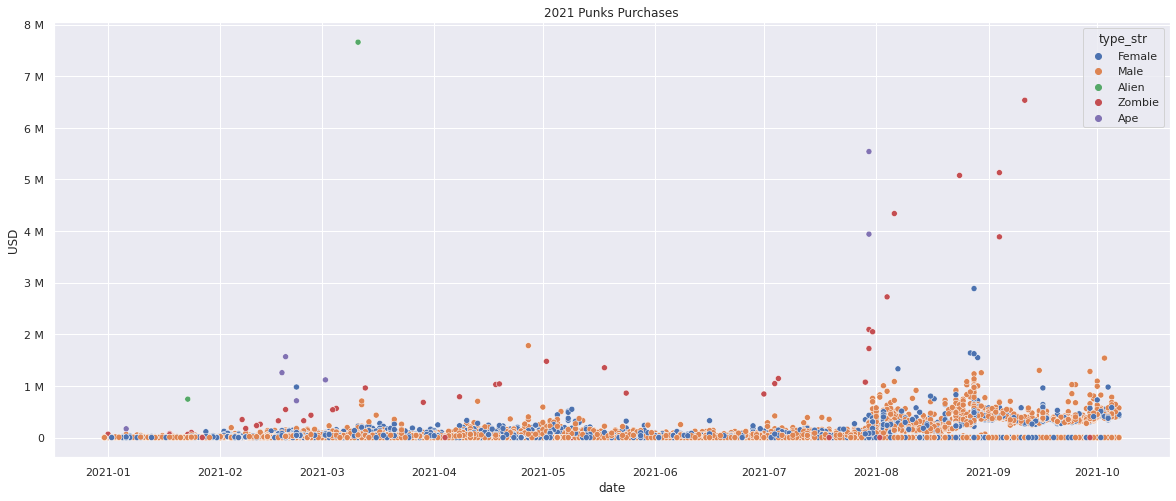

In [64]:
import matplotlib.ticker as ticker
sns.set(style="darkgrid")    
fig, ax = plt.subplots(figsize=(20, 8))    

g = sns.scatterplot(x=df_alt2['date'], y=df_alt2['USD'], hue=df_alt2['type_str']).set(title='2021 Punks Purchases')

ax.yaxis.set_major_formatter(ticker.EngFormatter())

In [68]:
n = 20
print('The users with the most selling transactions are:')
df_alt2['from'].value_counts()[:n]

The users with the most selling transactions are:


0xcbd482     703
0x577ebc     594
0xc352b5     544
Wilcox       301
0xca8fe4     261
0x1919db     231
0x6f4a2d     224
0x6611fe     222
0x650dcd     210
0xa3cb30     204
0x62bdc6     186
0x48db19     171
Pranksy      160
0x35388c     151
0x2cbee4     151
0x938bd2     150
sov          147
0x0e9aed     132
0xba7ccc     129
tonyherr…    128
Name: from, dtype: int64

In [69]:
print('The users with the most buying transactions are:')
df_alt2['to'].value_counts()[:n]

The users with the most buying transactions are:


0x577ebc     764
             390
wilcox.e…    291
0x269616     230
0xb88f61     216
0x650dcd     210
0x1919db     201
0x3be89b     169
0x0e9aed     156
0x2cbee4     151
0x35388c     151
0x938bd2     150
sov.eth      147
Pranksy      144
0xcffc33     129
0x062c54     114
0x62bdc6     107
0x24e267     106
0x0b88fd     105
0xd79b93     105
Name: to, dtype: int64

### More to come in Part 3!